# Quadrupolar Example: B2O3

## Setup

This cell isn't strictly necessary, but it's best practice to keep your Julia environments contained within a particular folder. This function simply activates the project structure of the folder that this notebook is in (creating if it does not exist). This ensures that only packages that you need are in the enviroment, saving some trouble with potential dependency issues.

In [1]:
using Pkg; Pkg.activate(".")

  Activating project at `~/SpectraFit-ABC-dev`


This cell grabs the latest version of SpectraFit from the development branch. This only needs to be run once every time the packages is updated, but its best to just run it every time so you don't miss an update. The second line should only need to be run once (by removing the '#'), and it adds the packages that this notebook will use that aren't SpectraFit

In [2]:
Pkg.add(PackageSpec(url="https://github.com/itscoe/SpectraFit.jl", rev="dev"));
# Pkg.add("Unitful"), Pkg.add("Random"); Pkg.add("Suppressor")

    Updating git-repo `https://github.com/itscoe/SpectraFit.jl`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/SpectraFit-ABC-dev/Project.toml`
  No Changes to `~/SpectraFit-ABC-dev/Manifest.toml`
Precompiling project...
  ✓ JSON
  ✓ GR
  ✓ Plots
  ✓ StatsPlots
  ✓ SpectraFit
  5 dependencies successfully precompiled in 54 seconds (190 already precompiled)
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


We have installed the packages, but we haven't told Julia that we want to use them, which is what this next cell is for. I'm supressing the warnings that propogate from Plots to SpectraFit, because it makes the notebook significantly messier.

In [3]:
using Suppressor
@suppress using SpectraFit, Unitful, Random
Unitful.register(SpectraFit);

The last setup step is to set the random seed. This means that for the same version of Julia, this notebook will always produce the same results (reproducibility!)

In [4]:
Random.seed!(0);

## Fitting

We will set up an experimental series, which is a set of spectra that vary for one independent variable. In this case, the composition is the same ($B_2O_3$), and the independent variable is the cooling rate that varies over eight orders of magnitude. These are in the example data, so we'll get the file name from that, and then we'll input the log of the cooling rate and a label for the independent variable. Finally, we want to fit each spectrum using the Zeeman interaction, a Quadrupolar interaction, and an isotropic chemical shift.

In [5]:
rates = ["Fast"   5;
         "Normal" 3;
         "Slow"  -3]

exp = ExperimentalSeries(
    ExperimentalSpectrum.(get_example_data.(map(x -> "B2O3$(x)Cool.txt", rates[:, 1])), 
        delim = "  ", range = (31.5u"MHz", 32.5u"MHz")),
    rates[:, 2],
    "Cooling Rate (log K/s)"
)

s = Spectrum(1, Zeeman, Quadrupolar, ChemicalShiftI)

Spectrum{1, 0, Tuple{Zeeman, Quadrupolar, ChemicalShiftI}}(((Zeeman(), Quadrupolar(0.0 ZV m^-2, 0.0, 0.0), ChemicalShiftI(0.0 MHz)),), ())

This cell fits using approximate Bayesian computations using a sequential Monte Carlo algorithm. This allows for an automatic selection of $\epsilon$ rather than requiring manual selection. Non-zero $\epsilon$ can cause bias that can be characterized (or depending on the assumption of the error parameter, can still be exact). Note that parallelism takes a *lot* more memory

In [6]:
smc_res = abc_smc(s, exp; parallel = true)

3-element Vector{NamedTuple{(:P, :W, :ϵ)}}:
 (P = MonteCarloMeasurements.Particles{Float64, 100}[3.0 ± 0.11, 0.124 ± 0.02, 0.11 ± 0.03, -0.0333 ± 0.0004], W = 0.01, ϵ = 0.0012482954490274066)
 (P = MonteCarloMeasurements.Particles{Float64, 96}[3.05 ± 0.1, 0.12 ± 0.022, 0.144 ± 0.029, -0.0558 ± 0.00034], W = 0.0104, ϵ = 0.0014732491006907659)
 (P = MonteCarloMeasurements.Particles{Float64, 96}[2.78 ± 0.14, 0.118 ± 0.019, 0.0726 ± 0.043, -0.0307 ± 0.00061], W = 0.0104, ϵ = 0.0018177546419199508)

## Plotting

This plot shows the parameters themselves. The posterior gives an estimate of the error parameter, but since the posteriors are generally not Gaussian, the standard deviation or other metrics of error aren't particularly representative. As a consequence, we use a violin plot, whose width shows the distribution of the parameters (somewhat analogous to a histogram on its side). $|Vzz|$ is the starting value proportional to the quadrupolar coupling constant, but it is what's fit, $\eta$ is the starting asymmetry parameter, $\rho$ represents the amount of disorder in the glass, and the shift is a small isotropic chemical shift (moving the theoretical spectra along the x axis). These parameters are set up from the Extended Czjzek Model, which both reduces the number of parameters and more realistically approximates the multivariate distribution of the parameters. Note the chemical shift is likely an experimental artifact.

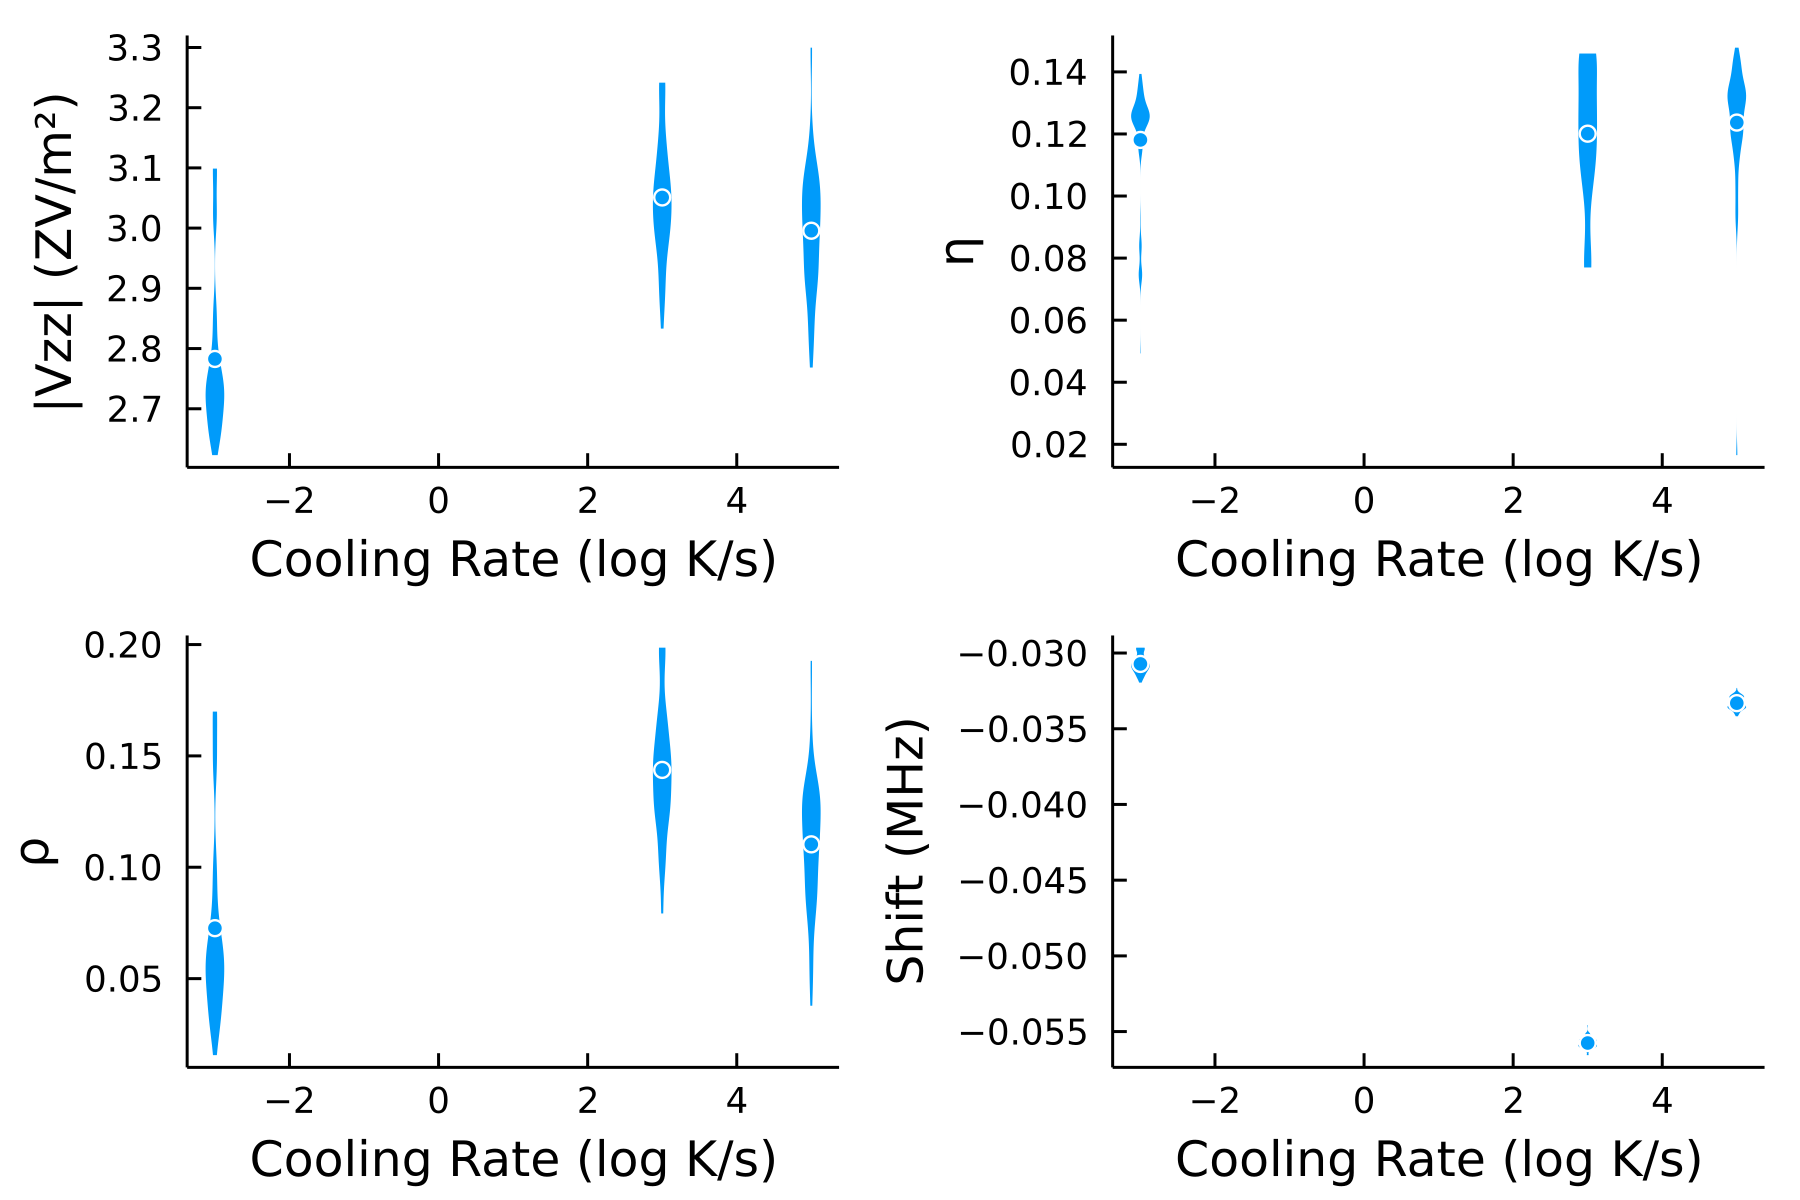

In [7]:
@suppress plot_parameters(exp, s, smc_res)

This plot shows the actual fits themselves (as a probability density estimate) and the ribbons show the full empirical basis for the 100 particles (standard deviations are unrealistic as these are also not normally distributed, and they are too small as well).

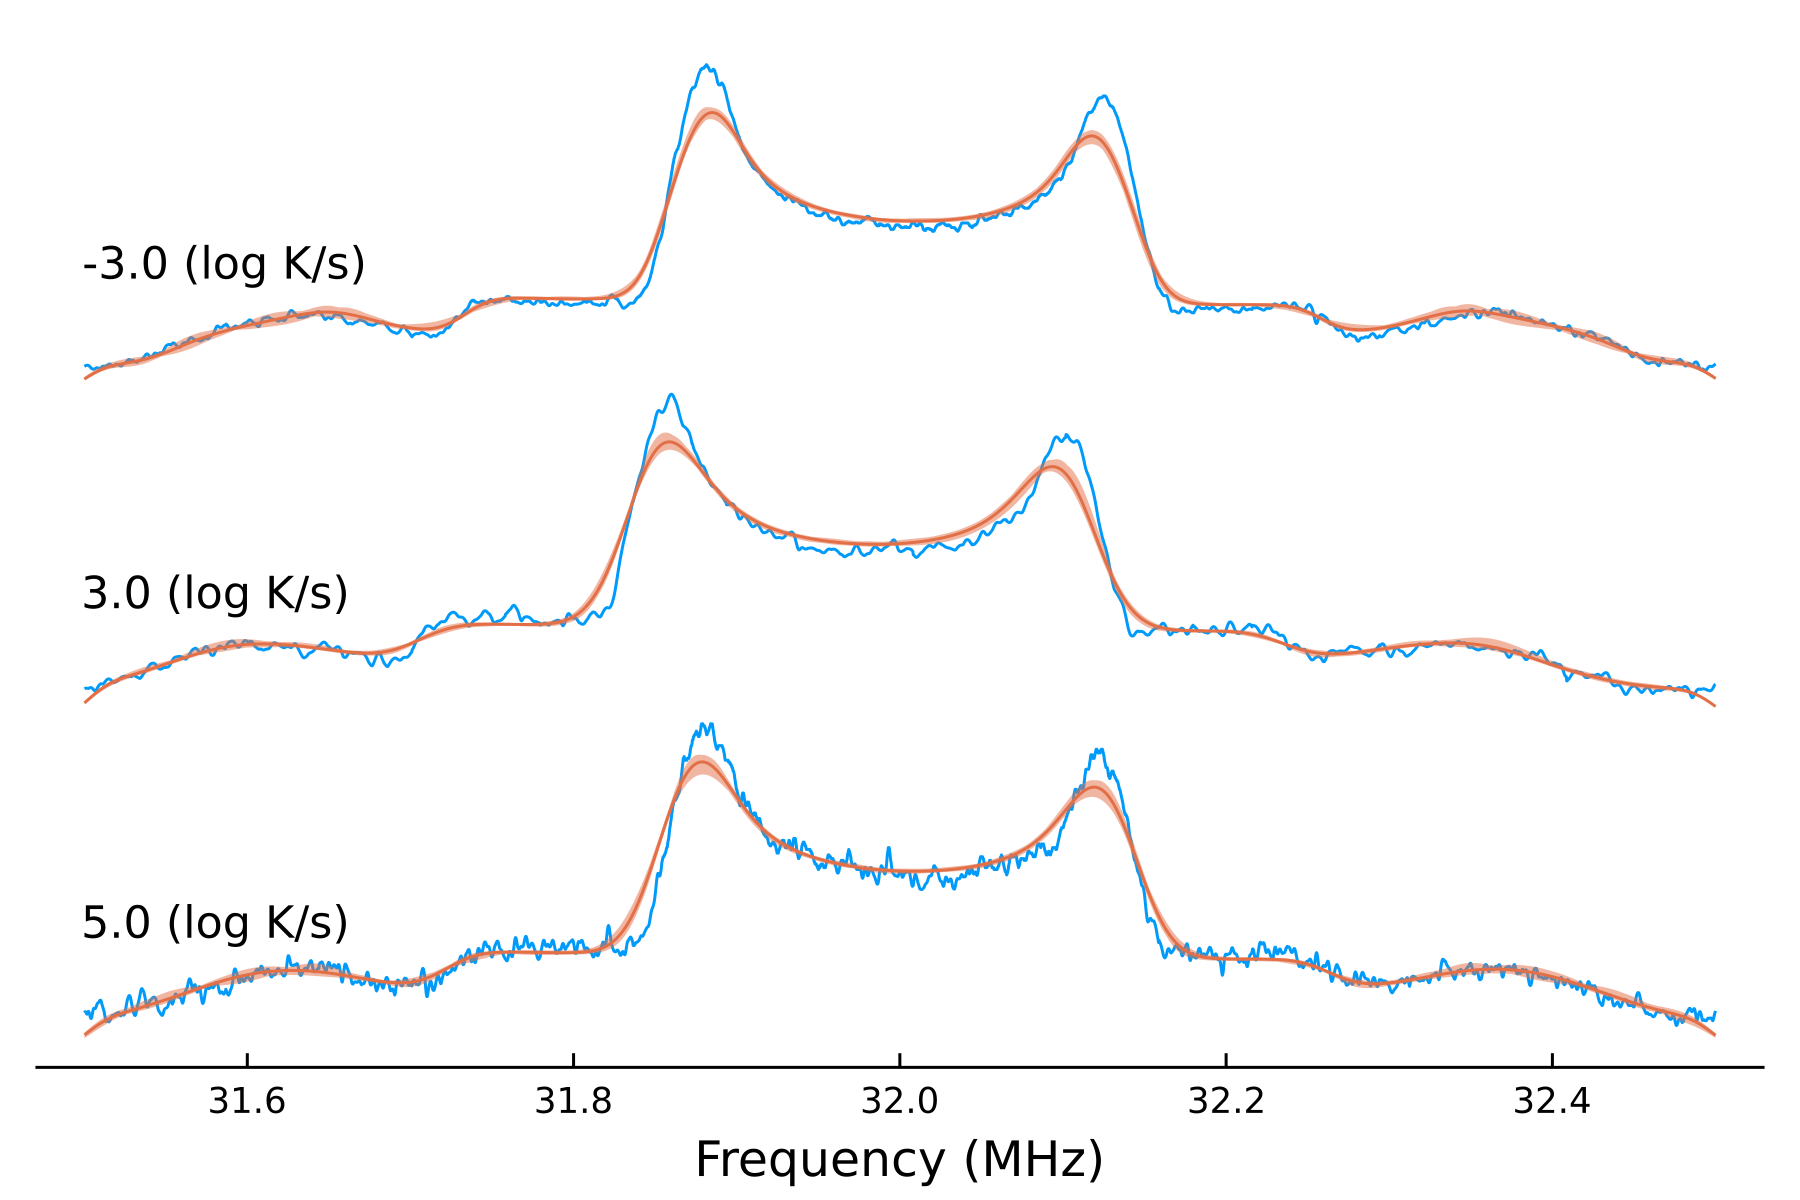

In [8]:
plot_fits(exp, s, smc_res)